In [11]:
import heapq
from collections import Counter
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgi
from numpy.random import binomial, choice, exponential, rand

sys.path.append("../src")
from helpers import count_prog_nonprog, grab, plot_frac_prog_group, plot_pref, plot_group_dist

sns.set_style("whitegrid")

In [2]:
# helpers 

def τ(n, p, α, β, b=0.9): # group benefits
    return np.exp(-α + β*(1 - c(n, p, b=b)))

def c(n, p, a=3, b=0.9): # cost function
    return b if n == p == 0 else b * np.exp(-a*p / n) 

def init_hypergraph():
    nb_groups = 1000
    max_group_size = 40
    
    current_node = 0
    hyperedge_dict = {}
    for group in range(nb_groups):
        group_size = binomial(max_group_size, 0.1)
        
        while group_size == 0: # make sure group size > 0
            group_size = binomial(max_group_size, 0.1)
        
        group_members = []
        for node in range(current_node, current_node+group_size):
            group_members.append(node)
        hyperedge_dict.update({group: group_members})
        current_node += group_size

    return xgi.Hypergraph(hyperedge_dict)

def pref_attachment_new_node(H):
    """return which new group new node we'll attach to"""
    all_gsizes = H.edges.size().asnumpy()
    dist_gsize = all_gsizes/all_gsizes.sum(axis=0,keepdims=1)
    return choice(H.edges, p=dist_gsize)

def whats_happening(event_queue, H, group, params, t):
    mu, nu_n, nu_p, alpha, beta, b = params
    p, n = count_prog_nonprog(H, group)

    R_nonprog_grad = nu_n * n
    R_prog_grad = nu_p * p
    R_new_nonprog = mu
    R_conversion_attempt = τ(n, p, alpha, beta, b=b) if n > 0 else 0.
    
    # draw time to next event and event type
    R = R_nonprog_grad + R_conversion_attempt + R_new_nonprog + R_prog_grad
    tau = exponential(scale=1/R)
    
    taulab = ["non-prog graduates", "programmer graduates", "conversion attempt", "new non-programmer"]
    tauR = [R_nonprog_grad/R, R_prog_grad/R, R_conversion_attempt/R, R_new_nonprog/R] 
    which_event = choice(taulab, p=tauR)
    
    if which_event == 'conversion attempt':
        if R_conversion_attempt/R < (1-c(n,p,b=b)):
            next_event = (tau, group, "new programmer", p, n)
        else:
            next_event = (tau, group, "non-prog leaves", p, n)

    next_event = (tau, group, which_event, p, n)

    heapq.heappush(event_queue, next_event)

    return event_queue

In [4]:
# parameters
mu  = 0.5
nu_n = 0.01
nu_p = 0.05
alpha  = 0.01
beta = 0.3 
# a = 3.   
b = .5
params = (mu, nu_n, nu_p, alpha, beta, b)

# #for each simulation
# for sims in range(10):
    
#initial conditions
event_queue = []
H = init_hypergraph()
I0 = 0.1
I = 0
Ig = np.zeros((21,21))
time = 0
for group, members in enumerate(H.edges.members()): #loop over groups
    # group, members = 0, H.edges.members(0)
    gsize = len(members)
    states_binary = binomial(gsize, I0, size=gsize)
    states = np.where(states_binary == 0, 'non-prog', 'prog')
    for node, state in zip(members, states):
        H.nodes[node]['state'] = state
    event_queue = whats_happening(event_queue, H, group, params, time)
    nb_prog = np.sum(states_binary)
    Ig[nb_prog, gsize-nb_prog] += 1
    I += nb_prog
# what's in the event queue?
Counter(e[2] for e in event_queue)

history = []
history_pref = []
history_group = []
tot_pop = []
history.append(I/H.num_nodes)
history_group.append(Ig/np.sum(Ig))
tot_pop.append(H.num_nodes)
times = np.zeros(1)

#for each generation
t_max = 5000
while time < t_max and len(event_queue) > 0:
    # draw from event queue
    (tau, group, event, p, n) = heapq.heappop(event_queue)
    
    while H.edges.get(group) is None:
        (tau, group, event, p, n) = heapq.heappop(event_queue)
    if event == 'non-programmer graduates' or event == "non-prog leaves":           
        leaving_node = grab(H, group, 'non-prog')
        # Not ideal.
        if leaving_node:
            H.remove_node(leaving_node)
            Ig[p, n]   -= 1
            Ig[p, n-1] += 1
            
    if event == 'programmer graduates':
        leaving_node = grab(H, group, 'prog')
        # Not ideal.
        if leaving_node:
            H.remove_node(leaving_node)
            I -= 1
            Ig[p, n]   -= 1
            Ig[p-1, n] += 1
    
    if event == 'new non-programmer':
        # A bit weird. Although the event is happening on a particular group
        # the new node decide to join another group proportional to gsize.
        # But you know..
        selected_group = pref_attachment_new_node(H)
        new_node = H.num_nodes+1
        H.add_node_to_edge(selected_group, new_node)
        H.nodes[new_node]['state'] = 'non-prog'
        # Now that we have a new programmer in that group, something else might happen.
        # Another students might join the university, another student in the same group
        # might try it too, etc.
        event_queue = whats_happening(event_queue, H, group, params, time)
        Ig[p, n+1] += 1
        Ig[p, n]   -= 1
        history_pref.append(selected_group)
    if event == 'new programmer':
        converting_node = grab(H, group, 'non-prog')
        # Not ideal.
        if converting_node:
            H.nodes[converting_node]['state'] = 'prog'
            I += 1
            Ig[p+1, n] += 1
            Ig[p, n]   -= 1
            # Now that we have a new programmer in that group, something else might happen.
            # Another students might join the university, another student in the same group
            # might try it too, etc.
            event_queue = whats_happening(event_queue, H, group, params, time)
    #update history
    time = time + tau
    tot_pop.append(H.num_nodes)
    history = np.append(history, I / H.num_nodes)
    history_group.append(Ig/np.sum(Ig))
    times = np.append(times, time)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


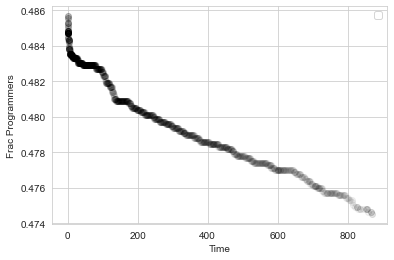

In [12]:
#print time series
plt.plot(times, history, marker="o", ls='--', color='black', alpha=0.05)
plt.ylabel('Frac Programmers')
plt.legend()
plt.xlabel('Time')
plt.plot(times[-1],history[-1], marker="o", ls='--', color='black', alpha=0.05, label='Simulations')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


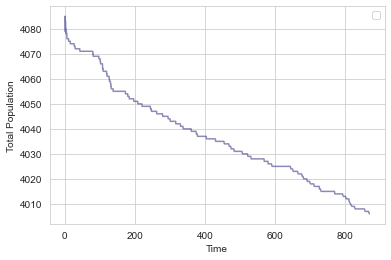

In [13]:
plt.plot(times, tot_pop, color='midnightblue', alpha=0.5)
plt.ylabel('Total Population') # pop decay for some reason
plt.legend()
plt.xlabel('Time')
plt.show()

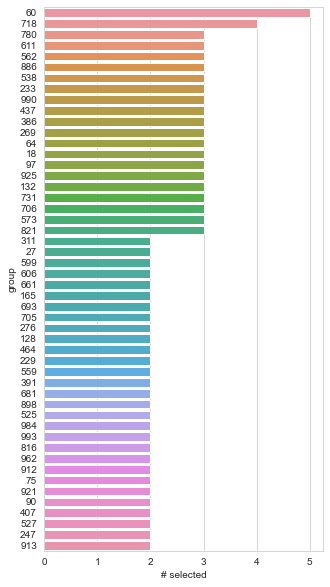

In [14]:
plot_pref(history_pref)

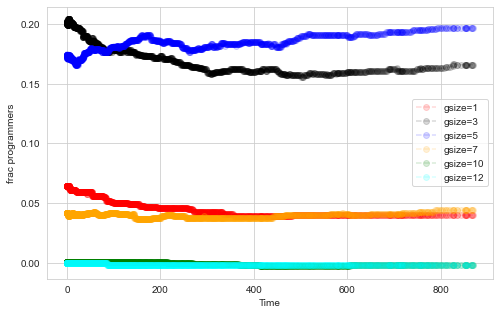

In [15]:
plot_frac_prog_group(history_group, times)